# Group 11 DL Project - Part A 

# Imports 

In [1]:
import gensim
from gensim.models import FastText
import tqdm
import math
import numpy as np
import pandas as pd
from torch.autograd import Variable
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from os import listdir
from os.path import isfile, join
import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
nltk.download('stopwords')
en_stops = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
import torch.optim as optim
import time
from sklearn.metrics import roc_curve, auc


C:\Users\YuvalZiv\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YuvalZiv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preprocessing

In [2]:
# Now we will make a new dataset from the files with positive and negative reviews

def make_clean_comments(dir_path, comment_type):
    #get all the files from the directory
    onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
    files_paths = [dir_path + "\\" + f for f in onlyfiles]
    
    comments_tokens = [] #[[tokens_from_1_file]:0/1,[tokens_from_2_file]...] e.t.c
    regex = re.compile('[^a-zA-Z]') #regex for removing all the symbols that are not letters
    
    #for each comment(=file in pos/neg directory)
    for path_to_file in files_paths:
        with open(path_to_file, encoding="utf8") as f:
            full_comment = f.read() #the data from file with comments
            words = full_comment.split() 
            clean_list = [] #this list will contain only words that doesn't have symbols other than letters
            
            #for each words in comment (=file)
            for w in words:
                clean_word_data = regex.sub('', w) #clean the word by regex
                
                if len(clean_word_data) > 1:
                    #cleaning the stopwords from the sentence
                    clean_word_data = clean_word_data.lower()
                    #checking that the word is not a stop word (=a word that shows up frequently)
                    if clean_word_data not in en_stops:
                        clean_list.append(clean_word_data) #creates a clean comment
                        
        comments_tokens.append(clean_list)
    #creating list of comment type for the later creation of dataset
    if comment_type == "pos":          
        comments_type = [1 for i in range(len(comments_tokens))]
    else:
        comments_type = [0 for i in range(len(comments_tokens))]

    return comments_tokens, comments_type

## Positive comments tokenization ##
pos_dir_path = fr"C:\Users\YuvalZiv\Desktop\Projects\nlp_project\train\pos"
pos_tokens_sentences, comments_type_list_pos = make_clean_comments(pos_dir_path, "pos")
## Negative comments tokenization ##
neg_dir_path = fr"C:\Users\YuvalZiv\Desktop\Projects\nlp_project\train\neg"
neg_tokens_sentences, comments_type_list_neg = make_clean_comments(neg_dir_path, "neg")
    

In [3]:
#preparing the labled data
data_pos = {'comment':pos_tokens_sentences,
        'lable':comments_type_list_pos}
data_neg = {'comment':neg_tokens_sentences,
        'lable':comments_type_list_neg}

#creating a dataset of all the data together
df_temp_1 = pd.DataFrame(data_pos, index=range(0,18750))
df_temp_2 = pd.DataFrame(data_neg, index=range(18750,37500))
dataset = pd.concat([df_temp_1,df_temp_2])

minimized_dataset = dataset.sample(10000,random_state=42)
data_for_embedding = minimized_dataset['comment'].values.tolist()

#finding max file length - for the padding in future so the files will be the same length
max_sentence = 0
for s in data_for_embedding:
    if len(s) > max_sentence:
        max_sentence = len(s)


### Embeddings training

In [4]:
''' Training the Embeddings '''

model_w2v = gensim.models.word2vec.Word2Vec(sentences=data_for_embedding, vector_size=100, window=5, min_count=1, workers=4)
model_w2v.train(data_for_embedding, total_examples=model_w2v.corpus_count, epochs=30)
if torch.cuda.is_available():
    model_w2v.cuda()
    
model_ft = FastText(sentences=data_for_embedding, vector_size=100, window=5, min_count=1, workers=4)
model_ft.train(data_for_embedding, total_examples=model_ft.corpus_count, epochs=30)
if torch.cuda.is_available():
    model_ft.cuda()
    


In [5]:
''' Padding the Embeddings '''

def make_indexed_torch(comment, embed_model):
    if embed_model == "w2v":
        
        return torch.LongTensor([model_w2v.wv.get_index(word) for word in comment])
    else:
        return torch.LongTensor([model_ft.wv.get_index(word) for word in comment])

def padding_tensors_to_the_same_dim(com_torch, target_size):
    nump_torch = com_torch.numpy()
    pad_size = target_size - nump_torch.size
    nump_torch = np.pad(nump_torch, (0,pad_size), 'constant')
    return torch.from_numpy(nump_torch)
    
    
# Preparing the inputs for our model training later    
comments = minimized_dataset['comment']
w2v_X_pp = comments.apply(lambda x: make_indexed_torch(x, "w2v"))
w2v_X = w2v_X_pp.apply(lambda x: padding_tensors_to_the_same_dim(x, max_sentence))
w2v_y = minimized_dataset['lable']

comments = minimized_dataset['comment']
ft_X_pp = comments.apply(lambda x: make_indexed_torch(x, "ft"))
ft_X = ft_X_pp.apply(lambda x: padding_tensors_to_the_same_dim(x, max_sentence))
ft_y = minimized_dataset['lable']



In [6]:
### Getting the weights from the training ###
w2v_weights = torch.FloatTensor(model_w2v.wv.vectors)
ft_weights = torch.FloatTensor(model_ft.wv.vectors)

## Building the Network

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, label_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.label_size = label_sz

        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.hidden2label = nn.Parameter(torch.Tensor(hidden_sz, label_sz))
        
        self.init_weights()
    
    def init_weights(self):
            stdv = 1.0 / math.sqrt(self.hidden_size)
            for weight in self.parameters():
                weight.data.uniform_(-stdv, stdv)
                
    
    def forward(self, x, init_states=None):
            """
            assumes x.shape represents (batch_size, sequence_size, input_size)
            """
            seq_sz, embeded_sz = x.size()
            
            if init_states is None:
                h_t, c_t = (
                    torch.zeros(self.hidden_size).to(x.device),
                    torch.zeros(self.hidden_size).to(x.device),
                )
            else:
                h_t, c_t = init_states

            #loop over all words in sequence
            
            for t in range(seq_sz):
                x_t = x[t]
                i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
                f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
                g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
                o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                    
                
                # last word:
                if t==seq_sz-1:
                    dropout = nn.Dropout(p=0.2)
                    out_ht = dropout(h_t)
                    y_pred = torch.sigmoid(out_ht @ self.hidden2label)
            
            return  y_pred

In [8]:
class LSTM_Model(nn.Module):
    def __init__(self,input_sz: int, hidden_sz: int, label_sz: int, embedding_weights):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = LSTM(input_sz, hidden_sz, label_sz)
    
    def forward(self,x):
        x_embeded = self.embedding(x)
        pred = self.lstm(x_embeded)
        return pred

## Training the model

In [11]:
'''
Creating the training loop
'''
def training_loop(X_input, y_input, data_size, test_p, classifier, epochs, criterion, optimizer):
    
    X = X_input[:data_size]
    y = y_input[:data_size]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_p, random_state=42)
    y_train = torch.from_numpy(y_train.values)
    y_test = torch.tensor(y_test.values)
    
    train_loss_list = []
    test_loss_list = []
    train_auc_list=[]
    test_auc_list=[]
    
    #for each epoch
    for e in tqdm(range(epochs)):
        
        train_label_list = []
        test_label_list = []
        train_pred_list = []
        test_pred_list = []

        running_loss = 0
        classifier.train()

        for i, comment in enumerate(X_train):
            
            label = y_train[i].view(1)
            comment, label = comment.to(device), label.to(device)
            optimizer.zero_grad()
            pred = classifier(comment).to(torch.float)
            label = label.to(torch.float)
            
            #loss calculation
            loss = criterion(pred, label)
            running_loss += loss.item()
            loss.backward()
            
            optimizer.step()
            
            #adding the results
            train_pred_list.append(pred.item())
            train_label_list.append(label.item())
        
        #updating the measurements
        epoch_train_loss = running_loss/len(X_train)
        train_loss_list.append(epoch_train_loss)
        fpr_t, tpr_t, thresholds_t = roc_curve(np.array(train_label_list), np.array(train_pred_list))
        train_auc = auc(fpr_t, tpr_t)
        train_auc_list.append(train_auc)
        
        test_loss = 0
        classifier.eval()
        
        #define no_grad() to save memory - cause there is no need in updating weights
        with torch.no_grad():
            for i, comment in enumerate(X_test):
                
                label = y_test[i].view(1)
                comment, label = comment.to(device), label.to(device)
                test_pred = classifier(comment).to(torch.float)
                label = label.to(torch.float)
                
                #loss calculation for test
                loss = criterion(test_pred, label)
                test_loss += loss.item()
                test_pred_list.append(test_pred.item())
                test_label_list.append(label.item())
        
        #updating the measurements for test
        epoch_test_loss = test_loss/len(X_test)
        test_loss_list.append(epoch_test_loss)
        fpr_v, tpr_v, thresholds_v = roc_curve(np.array(test_label_list),np.array(test_pred_list))
        test_auc = auc(fpr_v, tpr_v)
        test_auc_list.append(test_auc)
        

    return {'train_loss':train_loss_list,
            'train_auc':train_auc_list,
            'test_auc':test_auc_list,
            'test_loss':test_loss_list,
            'fpr_v':fpr_v,
            'tpr_v':tpr_v
            }


**Note:** The running took a lot of time, so we compared between the Embeddings and the Hidden sizes of the nets, due to time constraint 

We compared between 2 "types" of models (for each embedding, which makes it 4 models to run):

* **Model_1**: 10 hidden layers, learning rate = 0.01
* **Model_2**: 15 hidden layers, learning rate = 0.05

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
criterion = nn.BCELoss()
epochs = 30

### Creating 2 versions to compare for Word2Vec ###

net_w2v_1 = LSTM_Model(100, 10, 1 , w2v_weights).to(device)
optimizer_w2v_1 = optim.Adam(net_w2v_1.parameters(), lr = 0.01, weight_decay = 1e-3)

net_w2v_2 = LSTM_Model(100, 15, 1 , w2v_weights).to(device)
optimizer_w2v_2 = optim.Adam(net_w2v_2.parameters(), lr = 0.05, weight_decay = 1e-3)

### Creating 2 versions to comparison for FastText ###

net_ft_1 = LSTM_Model(100, 10, 1 , ft_weights).to(device)
optimizer_ft_1 = optim.Adam(net_ft_1.parameters(), lr = 0.01, weight_decay = 1e-3)

net_ft_2 = LSTM_Model(100, 15, 1 , ft_weights).to(device)
optimizer_ft_2 = optim.Adam(net_ft_2.parameters(), lr = 0.05, weight_decay = 1e-3)


### Run loop for Word2Vec ###
w2v_results_1 = training_loop(w2v_X.values,w2v_y,500,0.2,net_w2v_1,epochs,criterion,optimizer_w2v_1)
w2v_results_2 = training_loop(w2v_X.values,w2v_y,500,0.2,net_w2v_2,epochs,criterion,optimizer_w2v_2)

### Run loop for FastText ###
ft_results_1 = training_loop(w2v_X.values,w2v_y,500,0.2,net_ft_1,epochs,criterion,optimizer_ft_1)
ft_results_2 = training_loop(w2v_X.values,w2v_y,500,0.2,net_ft_2,epochs,criterion,optimizer_ft_2)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:36:37<00:00, 193.24s/it]


## Comparing models

### Train & Test results

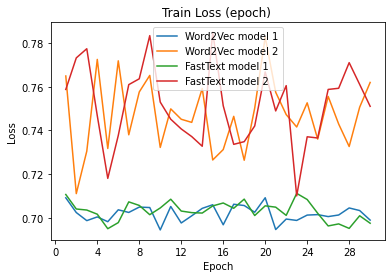

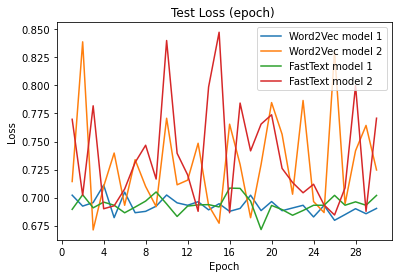

In [17]:
#plotting graphs to see what is the optimal number of epochs

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

x_epoch_label = range(1,epochs+1) # for the x-axis

## Plotting Train comparison ###

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

ax.plot(x_epoch_label,w2v_results_1['train_loss'],label="Word2Vec model 1")
ax.plot(x_epoch_label,w2v_results_2['train_loss'],label="Word2Vec model 2")

ax.plot(x_epoch_label,ft_results_1['train_loss'],label="FastText model 1")
ax.plot(x_epoch_label,ft_results_2['train_loss'],label="FastText model 2")

ax.set_title('Train Loss (epoch) ')

plt.legend()
plt.show()

## Plotting Test comparison ###

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

ax.plot(x_epoch_label,w2v_results_1['test_loss'],label="Word2Vec model 1")
ax.plot(x_epoch_label,w2v_results_2['test_loss'],label="Word2Vec model 2")

ax.plot(x_epoch_label,ft_results_1['test_loss'],label="FastText model 1")
ax.plot(x_epoch_label,ft_results_2['test_loss'],label="FastText model 2")

ax.set_title('Test Loss (epoch) ')

plt.legend()
plt.show()


### AUC (test) Results 

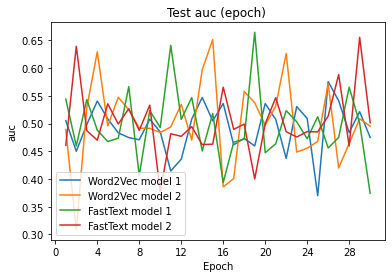

In [19]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('auc')
ax.set_xlabel('Epoch')

ax.plot(x_epoch_label,w2v_results_1['test_auc'],label="Word2Vec model 1")
ax.plot(x_epoch_label,w2v_results_2['test_auc'],label="Word2Vec model 2")

ax.plot(x_epoch_label,ft_results_1['test_auc'],label="FastText model 1")
ax.plot(x_epoch_label,ft_results_2['test_auc'],label="FastText model 2")

ax.set_title('Test auc (epoch) ')

plt.legend()
plt.show()

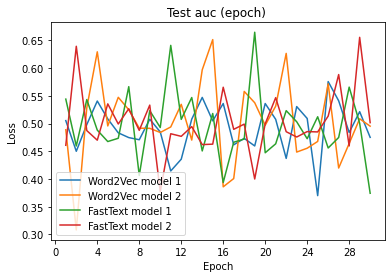

In [20]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

ax.plot(x_epoch_label,w2v_results_1['test_auc'],label="Word2Vec model 1")
ax.plot(x_epoch_label,w2v_results_2['test_auc'],label="Word2Vec model 2")

ax.plot(x_epoch_label,ft_results_1['test_auc'],label="FastText model 1")
ax.plot(x_epoch_label,ft_results_2['test_auc'],label="FastText model 2")

ax.set_title('Test auc (epoch) ')

plt.legend()
plt.show()

# Discussion
We can see that there is a significant difference  between the models with different learning rate and hidden size. The lower the learning rate the the lower the smaller the number of the layers is, the better.
In addition,  It is well clarified in the first loss graph of the train sets. Furthermore, The models are not stable, and if we would have more time and GPU power, we would have ran that with more epochs and we would check which hyper parameters are the best to adjust: the learning rate, the number of layers in the model etc.
Moreover, the auc results are almost the same for the all 4 moodels: not stable and there is a minor difference (less than 5%) between each other, but the loss difference is much more significant.
Due to low computing power and not enough time, we did combination of 2 hyper parameters adjustments and ran it. 
In conclusion, the result are not better than a random model (around 50% auc)